# Solar

In [ ]:
!pip install torch torchvision torchaudio matplotlib pandas scikit-learn --quiet

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
import sqlite3

In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect("energy_data_NE.db")

# Query weather data
weather_query = """
SELECT time, temperature, dwpt, humidity, precipitation, wdir, windspeed, pres, cloudcover
FROM historical_weather_data
"""
weather_data = pd.read_sql_query(weather_query, conn)

# Query energy data
energy_data = {
    'solar': pd.read_sql_query("SELECT datetime, value FROM SUN_data_NE", conn),
    'wind': pd.read_sql_query("SELECT datetime, value FROM WND_data_NE", conn),
    'demand': pd.read_sql_query("SELECT datetime, Demand as value FROM demand_data_NE", conn)
}

conn.close()

In [ ]:
# Rename and convert time columns
weather_data.rename(columns={'time': 'datetime'}, inplace=True)
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
for source in energy_data:
    energy_data[source]['datetime'] = pd.to_datetime(energy_data[source]['datetime'])

# Add temporal features to weather data
weather_data['hour'] = weather_data['datetime'].dt.hour
weather_data['month'] = weather_data['datetime'].dt.month
weather_data['season'] = ((weather_data['datetime'].dt.month - 1) // 3 + 1).astype(int)

# Scale weather features
scaler = MinMaxScaler()
scaled_weather = scaler.fit_transform(weather_data[['temperature', 'dwpt', 'humidity',
                                                    'precipitation', 'wdir', 'windspeed',
                                                    'pres', 'cloudcover', 'hour', 'month']])

# Scale energy data
energy_scalers = {}
for source, data in energy_data.items():
    energy_scalers[source] = MinMaxScaler()
    energy_data[source]['value'] = energy_scalers[source].fit_transform(data[['value']])

In [ ]:
class EnergyDataset(Dataset):
    def __init__(self, weather_data, energy_data, sequence_length):
        self.weather_data = weather_data
        self.energy_data = energy_data
        self.sequence_length = sequence_length
        self.length = len(weather_data) - sequence_length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x = torch.tensor(self.weather_data[idx:idx+self.sequence_length], dtype=torch.float32)
        y = {
            source: torch.tensor(self.energy_data[source]['value'][idx+self.sequence_length], dtype=torch.float32)
            for source in self.energy_data
        }
        return x, y

In [ ]:
class EnergyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(EnergyRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last LSTM output
        return out

In [ ]:
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = {k: v.to(device) for k, v in y_batch.items()}

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = sum(criterion(outputs[:, i], y_batch[source]) for i, source in enumerate(y_batch))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    return losses

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = {source: [] for source in energy_data}
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch).cpu().numpy()
            predictions.append(outputs)
            for source in y_batch:
                actuals[source].append(y_batch[source].cpu().numpy())
    return np.concatenate(predictions), {source: np.concatenate(values) for source, values in actuals.items()}

In [ ]:
# Hyperparameters
sequence_length = 24
batch_size = 32
hidden_size = 128
num_epochs = 20
learning_rate = 0.001
output_size = len(energy_data)

# Create dataset and data loaders
dataset = EnergyDataset(scaled_weather, energy_data, sequence_length)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnergyRNN(input_size=scaled_weather.shape[1], hidden_size=hidden_size, output_size=output_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()

Epoch 1/20, Loss: 0.0733
Epoch 2/20, Loss: 0.0410
Epoch 3/20, Loss: 0.0367
Epoch 4/20, Loss: 0.0347
Epoch 5/20, Loss: 0.0335
Epoch 6/20, Loss: 0.0330
Epoch 7/20, Loss: 0.0316
Epoch 8/20, Loss: 0.0312
Epoch 9/20, Loss: 0.0305
Epoch 10/20, Loss: 0.0295
Epoch 11/20, Loss: 0.0294
Epoch 12/20, Loss: 0.0288
Epoch 13/20, Loss: 0.0280
Epoch 14/20, Loss: 0.0278
Epoch 15/20, Loss: 0.0271
Epoch 16/20, Loss: 0.0266
Epoch 17/20, Loss: 0.0263
Epoch 18/20, Loss: 0.0257
Epoch 19/20, Loss: 0.0254
Epoch 20/20, Loss: 0.0248


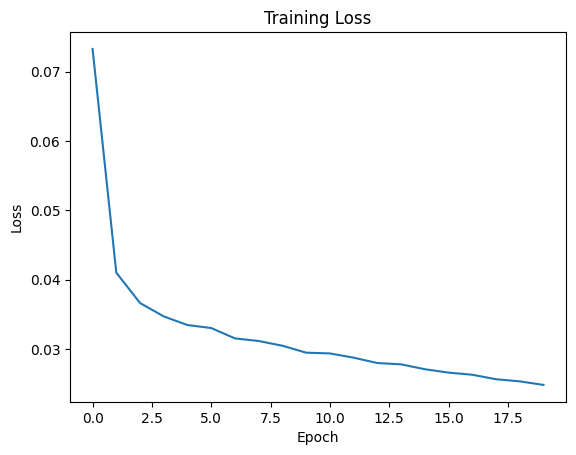

In [ ]:
# Train the model
losses = train_model(model, train_loader, optimizer, criterion, num_epochs)

# Plot training loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Evaluate the model
predictions, actuals = evaluate_model(model, test_loader)

# Inverse transform predictions and actuals
predictions_inverse = energy_scalers['solar'].inverse_transform(predictions[:, [0]])
actuals_inverse = energy_scalers['solar'].inverse_transform(actuals['solar'].reshape(-1, 1))

# Metrics
mae = mean_absolute_error(actuals_inverse, predictions_inverse)
rmse = np.sqrt(mean_squared_error(actuals_inverse, predictions_inverse))
r2 = r2_score(actuals_inverse, predictions_inverse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R-squared (R^2): {r2:.4f}")

Mean Absolute Error (MAE): 35.9258
Root Mean Square Error (RMSE): 62.4584
R-squared (R^2): 0.8813


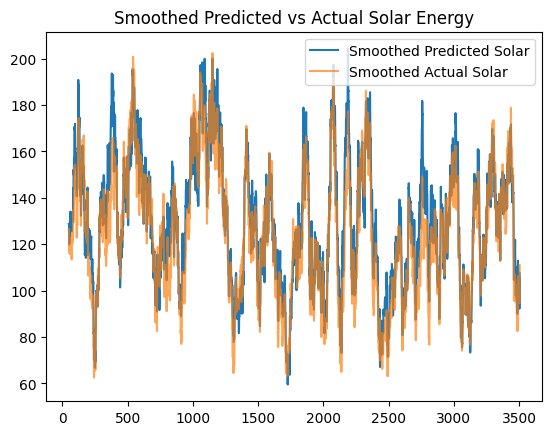

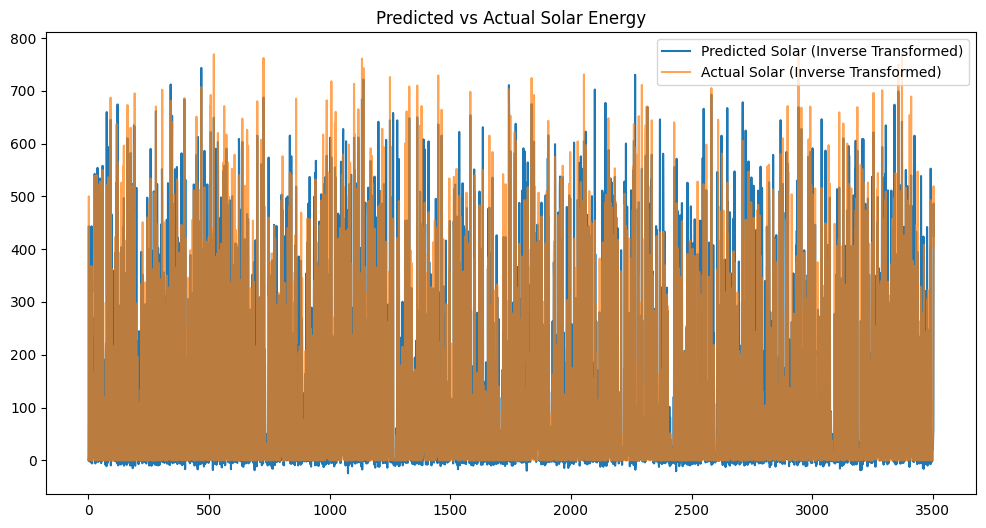

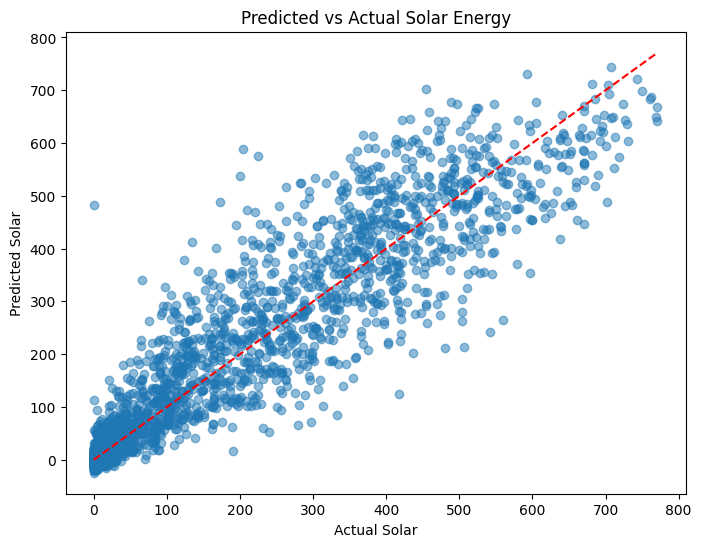

In [ ]:
window_size = 50  # Adjust as needed
pred_smooth = pd.Series(predictions_inverse.flatten()).rolling(window=window_size).mean()
actual_smooth = pd.Series(actuals_inverse.flatten()).rolling(window=window_size).mean()

plt.plot(pred_smooth, label="Smoothed Predicted Solar")
plt.plot(actual_smooth, label="Smoothed Actual Solar", alpha=0.7)
plt.legend()
plt.title("Smoothed Predicted vs Actual Solar Energy")
plt.show()

# Visualize predictions vs actuals for solar energy
plt.figure(figsize=(12, 6))
plt.plot(predictions_inverse, label="Predicted Solar (Inverse Transformed)")
plt.plot(actuals_inverse, label="Actual Solar (Inverse Transformed)", alpha=0.7)
plt.legend()
plt.title("Predicted vs Actual Solar Energy")
plt.show()

# Scatter plot for predicted vs actuals
plt.figure(figsize=(8, 6))
plt.scatter(actuals_inverse, predictions_inverse, alpha=0.5)
plt.title("Predicted vs Actual Solar Energy")
plt.xlabel("Actual Solar")
plt.ylabel("Predicted Solar")
plt.plot([0, np.max(actuals_inverse)], [0, np.max(actuals_inverse)], color="red", linestyle="--")  # Reference diagonal
plt.show()

# Demand

In [26]:
!pip install torch torchvision torchaudio matplotlib pandas scikit-learn --quiet

In [27]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
import sqlite3


In [28]:
# Connect to the SQLite database
conn = sqlite3.connect("energy_data_NE.db")

# Query weather data
weather_query = """
SELECT time, temperature, dwpt, humidity, precipitation, wdir, windspeed, pres, cloudcover
FROM historical_weather_data
"""
weather_data = pd.read_sql_query(weather_query, conn)

# Query demand data
demand_query = "SELECT datetime, Demand as value FROM demand_data_NE"
demand_data = pd.read_sql_query(demand_query, conn)

conn.close()

# Rename and convert time columns
weather_data.rename(columns={'time': 'datetime'}, inplace=True)
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
demand_data['datetime'] = pd.to_datetime(demand_data['datetime'])

# Add temporal features to weather data
weather_data['hour'] = weather_data['datetime'].dt.hour
weather_data['month'] = weather_data['datetime'].dt.month
weather_data['season'] = ((weather_data['datetime'].dt.month - 1) // 3 + 1).astype(int)

# Merge weather and demand data
merged_data = pd.merge(weather_data, demand_data, on='datetime', how='inner')


In [29]:
# Scale features and target
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(merged_data[[
    'temperature', 'dwpt', 'humidity', 'precipitation',
    'wdir', 'windspeed', 'pres', 'cloudcover', 'hour', 'month'
]])
scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(merged_data[['value']])


In [30]:
class EnergyDataset(Dataset):
    def __init__(self, features, target, sequence_length):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx:idx+self.sequence_length], dtype=torch.float32)
        y = torch.tensor(self.target[idx+self.sequence_length], dtype=torch.float32)
        return x, y


In [31]:
class EnergyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(EnergyRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last LSTM output
        return out


In [32]:
# Hyperparameters
sequence_length = 24
batch_size = 32
hidden_size = 128
num_epochs = 20
learning_rate = 0.001

# Prepare data
dataset = EnergyDataset(scaled_features, scaled_target, sequence_length)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnergyRNN(input_size=scaled_features.shape[1], hidden_size=hidden_size, output_size=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [34]:
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch.view(-1, 1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    return losses


Epoch 1/20, Loss: 0.0122
Epoch 2/20, Loss: 0.0051
Epoch 3/20, Loss: 0.0037
Epoch 4/20, Loss: 0.0033
Epoch 5/20, Loss: 0.0030
Epoch 6/20, Loss: 0.0028
Epoch 7/20, Loss: 0.0027
Epoch 8/20, Loss: 0.0026
Epoch 9/20, Loss: 0.0026
Epoch 10/20, Loss: 0.0026
Epoch 11/20, Loss: 0.0024
Epoch 12/20, Loss: 0.0024
Epoch 13/20, Loss: 0.0024
Epoch 14/20, Loss: 0.0023
Epoch 15/20, Loss: 0.0023
Epoch 16/20, Loss: 0.0023
Epoch 17/20, Loss: 0.0022
Epoch 18/20, Loss: 0.0022
Epoch 19/20, Loss: 0.0022
Epoch 20/20, Loss: 0.0022


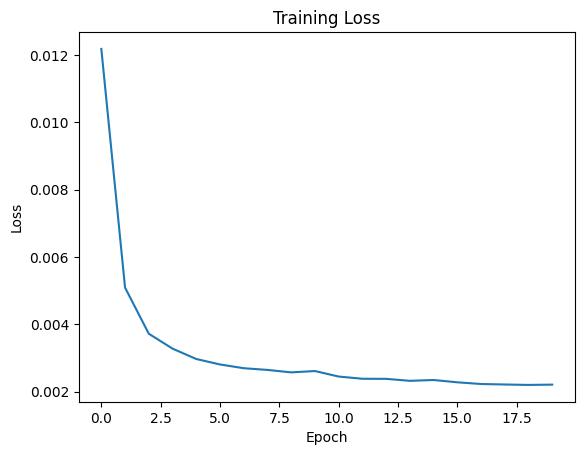

In [35]:
# Train the model
losses = train_model(model, train_loader, optimizer, criterion, num_epochs)

# Plot training loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [36]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch).cpu().numpy()
            predictions.extend(outputs)
            actuals.extend(y_batch.numpy())
    return np.array(predictions), np.array(actuals)

# Evaluate the model
predictions, actuals = evaluate_model(model, test_loader)


Mean Absolute Error (MAE): 597.0381
Root Mean Square Error (RMSE): 780.8439
R-squared (R²): 0.8954


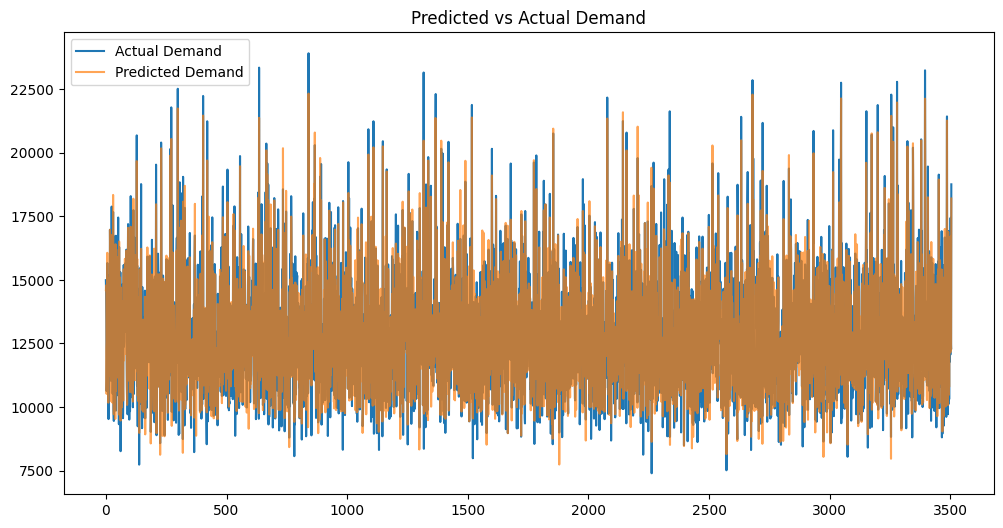

In [37]:
# Inverse transform predictions and actuals
predictions_inverse = scaler_target.inverse_transform(predictions)
actuals_inverse = scaler_target.inverse_transform(actuals)

# Metrics
mae = mean_absolute_error(actuals_inverse, predictions_inverse)
rmse = np.sqrt(mean_squared_error(actuals_inverse, predictions_inverse))
r2 = r2_score(actuals_inverse, predictions_inverse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Visualize predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(actuals_inverse, label="Actual Demand")
plt.plot(predictions_inverse, label="Predicted Demand", alpha=0.7)
plt.legend()
plt.title("Predicted vs Actual Demand")
plt.show()


# Wind

In [38]:
!pip install xgboost pandas matplotlib joblib scikit-learn --quiet


In [46]:
# Import necessary libraries
import sqlite3
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect("energy_data_NE.db")

# Query weather data
weather_query = """
SELECT time, temperature, dwpt, humidity, precipitation, wdir, windspeed, pres, cloudcover
FROM historical_weather_data
"""
weather_data = pd.read_sql_query(weather_query, conn)

# Query wind data
wind_query = "SELECT datetime, value FROM WND_data_NE"
wind_data = pd.read_sql_query(wind_query, conn)

conn.close()

# Rename and merge data
weather_data.rename(columns={'time': 'datetime'}, inplace=True)
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
wind_data['datetime'] = pd.to_datetime(wind_data['datetime'])

# Add temporal features to weather data
weather_data['hour'] = weather_data['datetime'].dt.hour
weather_data['month'] = weather_data['datetime'].dt.month
weather_data['season'] = ((weather_data['datetime'].dt.month - 1) // 3 + 1).astype(int)

# Merge weather and wind data
merged_data = pd.merge(weather_data, wind_data, on='datetime', how='inner')

# Prepare features and target
X = merged_data[['temperature', 'dwpt', 'humidity', 'precipitation', 'wdir', 'windspeed', 'pres', 'cloudcover', 'hour', 'month', 'season']].values
y = merged_data['value'].values

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Create sequences for RNN
def create_sequences(data_X, data_y, seq_length=24):
    X_seq, y_seq = [], []
    for i in range(len(data_X) - seq_length):
        X_seq.append(data_X[i:i+seq_length])
        y_seq.append(data_y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length=sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [47]:
class WindRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(WindRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last LSTM output
        return out


In [48]:
# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 20
batch_size = 32

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WindRNN(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


Epoch 1/20, Loss: 0.0350
Epoch 2/20, Loss: 0.0270
Epoch 3/20, Loss: 0.0248
Epoch 4/20, Loss: 0.0237
Epoch 5/20, Loss: 0.0230
Epoch 6/20, Loss: 0.0222
Epoch 7/20, Loss: 0.0219
Epoch 8/20, Loss: 0.0214
Epoch 9/20, Loss: 0.0210
Epoch 10/20, Loss: 0.0204
Epoch 11/20, Loss: 0.0200
Epoch 12/20, Loss: 0.0195
Epoch 13/20, Loss: 0.0190
Epoch 14/20, Loss: 0.0188
Epoch 15/20, Loss: 0.0178
Epoch 16/20, Loss: 0.0177
Epoch 17/20, Loss: 0.0167
Epoch 18/20, Loss: 0.0165
Epoch 19/20, Loss: 0.0158
Epoch 20/20, Loss: 0.0154


Mean Absolute Error (MAE): 118.66
Root Mean Square Error (RMSE): 153.04
R-squared (R^2): 0.72


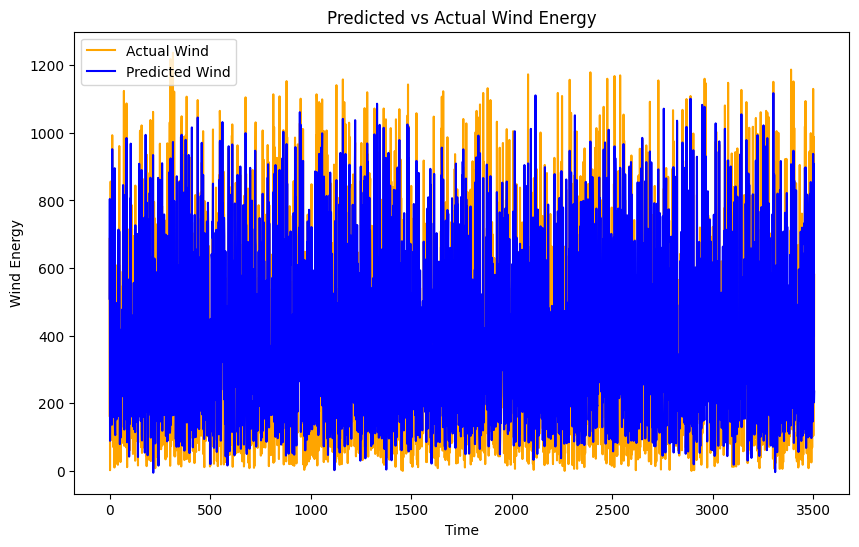

In [49]:
# Evaluate the model
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    predictions = model(X_test_tensor).cpu().numpy()
    actuals = y_test_tensor.numpy()

# Inverse transform predictions and actuals
predictions_inverse = scaler_y.inverse_transform(predictions)
actuals_inverse = scaler_y.inverse_transform(actuals)

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(actuals_inverse, predictions_inverse)
rmse = np.sqrt(mean_squared_error(actuals_inverse, predictions_inverse))
r2 = r2_score(actuals_inverse, predictions_inverse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(actuals_inverse, label="Actual Wind", color="orange")
plt.plot(predictions_inverse, label="Predicted Wind", color="blue")
plt.legend()
plt.title("Predicted vs Actual Wind Energy")
plt.xlabel("Time")
plt.ylabel("Wind Energy")
plt.show()
